<a href="https://colab.research.google.com/github/kaushaln1/ML_DM_labs/blob/main/ML/MachineLearning_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 436 / 536: Introduction to Machine Learning
# Spring 2022
## Learning with Regularization and Validation

##### This file relies upon several functions implemented previously in the notebook on Linear Models.

In [ ]:
!pip install ipynb
# from ipynb.fs.full.LinearModels import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
Dependencies
'''
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

In [ ]:
'''
Compute the augmented matrix with features
Helper Functions
'''

def computeIntensity(X):
    '''
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        intensities: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     average pixel intesity of the corresponding image
                     See LFD Example 3.1
    '''
    print('computing intensity feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    '''
    TODO: Compute the intensity feature for N data points
    '''
    intensities = []
    for i in range(0,N):
      avg=sum(X[i])/d
      intensities.append(avg)

    intensities = np.array(intensities)
    intensities= intensities.reshape(N, 1)
    print(f'Output shape {intensities.shape}')

    return intensities


def computeSymmetry(X):
    '''
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        symmetries: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     "horizontal" symmetry of the 16 x 16 image about the vertical axis
                     See LFD Example 3.1
    '''
    print('computing symmetry feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    Ximgs = [X[n, :].reshape((16, 16)) for n in range(N)]
    Ximgs_flipped = [np.flip(Ximgs[n], axis=1) for n in range(N)]
    '''
    TODO: Compute the symmetry feature for N data points
    '''

    Ximgs = np.array(Ximgs)
    Ximgs_flipped = np.array(Ximgs_flipped)

    symmetries = []
    for i in range (0, N):
      avg_absolute_diff = sum(sum(abs(np.subtract(Ximgs[i] , Ximgs_flipped[i]))))/d
      symmetries.append(avg_absolute_diff)
    symmetries = np.array(symmetries)
    symmetries = symmetries.reshape(N, 1)
    print(f'Output shape {symmetries.shape}')
    return -symmetries


def computeAugmentedXWithFeatures(X):
    '''
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        Xaug: a 2 dimensional N x 3 numpy array
              the augmented feature matrix
              the i-th row corresponds to the i-th row of X (and image represented by it)
              the 0-th column is the column of 1s
              the 1-st column is the column of average intensities
              the 2-nd column is the column of horizontal symmetries
    '''
    N, d = X.shape
    intensity = computeIntensity(X)
    symmetry = computeSymmetry(X)
    dummy = np.ones((N, 1))
    Xaug = np.concatenate((dummy, intensity, symmetry), axis=1)
    # print(Xaug)
    print (f'Shape of augmented feature matrix: {Xaug.shape}')
    return Xaug


In [ ]:
'''
Reading the MNIST/USPS Handwritten Digits Dataset
'''

def readData(fname='ZipDigits.train'):
    '''
    Input:
        fname: name of file containing N examples, each with d attributes
    Output:
        X: N x d+1 numpy array
        y: N x 1 numpy array
    '''
    with open(fname) as f:
        X = []
        y = []
        rlines = f.readlines()
        for line in rlines:
            row = line.rstrip().split(' ')
            yval = int(float(row[0]))
            y.append(yval)
            xvals = [float(pixel) for pixel in row[1:]]
            X.append(xvals)
        X = np.array(X)
        y = np.array(y)
        y = y.reshape((y.shape[0], 1))
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

In [ ]:
Xdigitstrain, ydigitstrain = readData('/content/drive/MyDrive/Colab Notebooks/ZipDigits.train')

Ndigitstrain, pixels = Xdigitstrain.shape

assert(Ndigitstrain == ydigitstrain.shape[0])

print(f'Xdigitstrain shape {Xdigitstrain.shape}, ydigitstrain shape {ydigitstrain.shape}')

X shape: (7291, 256)
y shape: (7291, 1)
Xdigitstrain shape (7291, 256), ydigitstrain shape (7291, 1)


In [ ]:
Xdigitstest, ydigitstest = readData('/content/drive/MyDrive/Colab Notebooks/ZipDigits.test')

Ndigitstest, pixels = Xdigitstest.shape

assert(Ndigitstest == ydigitstest.shape[0])

print(f'Xdigitstest shape {Xdigitstest.shape}, ydigitstest shape {ydigitstest.shape}')

X shape: (2007, 256)
y shape: (2007, 1)
Xdigitstest shape (2007, 256), ydigitstest shape (2007, 1)


## Feature Normalization

### Compute 'Augmented' Feature Matrix

In [ ]:
print('Computing augmented training feature matrix')

Xaugtrain = computeAugmentedXWithFeatures(Xdigitstrain)

Naugtrain, d = Xaugtrain.shape

print(f'Xaugtrain shape {Xaugtrain.shape}')

Computing augmented training feature matrix
computing intensity feature
Input shape 7291, 256
Output shape (7291, 1)
computing symmetry feature
Input shape 7291, 256
Output shape (7291, 1)
Shape of augmented feature matrix: (7291, 3)
Xaugtrain shape (7291, 3)


In [ ]:
print('Computing augmented test feature matrix')

Xaugtest = computeAugmentedXWithFeatures(Xdigitstest)

Naugtest, d = Xaugtest.shape

print(f'Xaugtest shape {Xaugtest.shape}')

Computing augmented test feature matrix
computing intensity feature
Input shape 2007, 256
Output shape (2007, 1)
computing symmetry feature
Input shape 2007, 256
Output shape (2007, 1)
Shape of augmented feature matrix: (2007, 3)
Xaugtest shape (2007, 3)


### Combine Data

#### Wait a minute... But I thought...

Well, Yes...

In [ ]:
Xaug = np.concatenate((Xaugtrain, Xaugtest), axis=0)
Naug, d = Xaug.shape
ycombined = np.concatenate((ydigitstrain, ydigitstest), axis=0)

assert(Xaug.shape[0] == Ndigitstrain + Ndigitstest)
assert(ycombined.shape[0] == Ndigitstrain + Ndigitstest)

print(f'Xaug shape {Xaug.shape}, ycombined shape {ycombined.shape}')

Xaug shape (9298, 3), ycombined shape (9298, 1)


Plot Xaug with features

In [ ]:
#test
'''
Create the dataset wih digits 1 and 5
'''

def indexDigits(y):
    '''
    Input:
        y: N x 1 2 dimensional numpy array; labels for handwritten digits
    Output:
        digit_idxs: a dictionary; the keys are digits 0 -- 9
                    for a digit k, digit_idxs[k] is a list identifying the rows labeled with digit k
    '''
    N = y.shape[0]
    digit_idxs = {}
    for n in range(N):
        digit = ycombined[n, 0]
        if not digit in digit_idxs:
            digit_idxs[digit] = []
        digit_idxs[digit].append(n)
    return digit_idxs


In [ ]:
# '''
# Plot the training data
# '''
# fig, axs = plt.subplots(figsize=(5,5))
# axs.scatter(X1train[:, 1], X1train[:, 2], marker='o', color='blue', label='1')
# axs.scatter(X5train[:, 1], X5train[:, 2], marker='x', color='red', label = '5')
# axs.set_xlabel('intensity')
# axs.set_ylabel('symmetry')
# #axs.set_xlim(-1, 0.2)
# #axs.set_ylim(1, 2)
# axs.set_title('1s and 5s in training ')
# axs.legend()



In [ ]:
!pip install scikit-learn

### Normalize Features

#### Warning! What is happening here? What are we doing here?

In [ ]:
from sklearn import preprocessing

def normalize_column(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    norm_arr = t_min + ((arr - np.min(arr)) * (diff) / (diff_arr))
    print("Norma arrs")
    print(norm_arr)
    print(norm_arr.shape)
    print(arr.shape)
    #print(max(norm_arr))
    #print(min(norm_arr))
    return norm_arr

def normalize(X, a=-1, b=1):
    N, d = X.shape
    Xnorm = np.ones((N, d))
    for col in range(1, d, 1):
        Xcol = X[:, col]
        # TODO: Complete this implementation
        # Complete
        print("colstats")
        print(Xcol)
        print(max(Xcol))
        print(min(Xcol))
        Xcolnorm = normalize_column(Xcol,-1,1)
        Xnorm[:, col] = Xcolnorm
    return Xnorm

In [ ]:
Xnorm = normalize(Xaug,-1,1)
N, d = Xnorm.shape
print(max(Xnorm[:,1]))
print(max(Xnorm[:,2]))
print(min(Xnorm[:,1]))
print(min(Xnorm[:,2]))
#Xscinorm = preprocessing.normalize([Xaug])
assert(Xnorm.shape == Xaug.shape)
assert(np.all( Xnorm[:, 0] == np.ones((N, 1)) ))

colstats
[-0.31781641 -0.11173828 -0.53799609 ... -0.38228516  0.01994141
 -0.62204687]
0.3118828125
-0.9063593750000001
Norma arrs
[-0.03378331  0.30453715 -0.39525443 ... -0.13962228  0.52071697
 -0.53324141]
(9298,)
(9298,)
colstats
[-0.37921094 -0.53372656 -0.44300781 ... -0.65989844 -0.32650781
 -0.13395312]
-0.0165390625
-1.0653906249999998
Norma arrs
[ 0.30844003  0.0138023   0.18678912 ... -0.22678823  0.40893686
  0.77610929]
(9298,)
(9298,)
1.0
1.0
-1.0
-1.0


{6: [0, 5, 31, 50, 55, 56, 89, 91, 99, 117, 118, 145, 150, 155, 162, 167, 172, 224, 228, 239, 242, 257, 264, 267, 282, 287, 292, 297, 306, 315, 336, 358, 366, 367, 368, 369, 374, 379, 384, 389, 394, 397, 398, 399, 404, 408, 413, 418, 422, 423, 427, 432, 437, 442, 445, 450, 455, 460, 465, 468, 470, 478, 483, 488, 497, 502, 507, 512, 517, 523, 525, 531, 561, 586, 594, 604, 609, 626, 634, 650, 720, 773, 783, 802, 806, 825, 831, 846, 854, 855, 861, 866, 880, 881, 899, 914, 929, 963, 966, 972, 985, 986, 987, 994, 1023, 1039, 1044, 1049, 1054, 1057, 1062, 1067, 1072, 1123, 1127, 1128, 1133, 1136, 1138, 1142, 1143, 1160, 1175, 1274, 1283, 1303, 1304, 1309, 1314, 1324, 1338, 1339, 1356, 1367, 1376, 1379, 1441, 1461, 1496, 1522, 1537, 1538, 1541, 1550, 1557, 1584, 1592, 1623, 1671, 1675, 1690, 1726, 1753, 1771, 1774, 1776, 1781, 1789, 1796, 1801, 1806, 1814, 1818, 1831, 1840, 1876, 2009, 2022, 2028, 2056, 2058, 2062, 2065, 2070, 2071, 2077, 2078, 2095, 2181, 2193, 2219, 2224, 2247, 2248, 2277, 

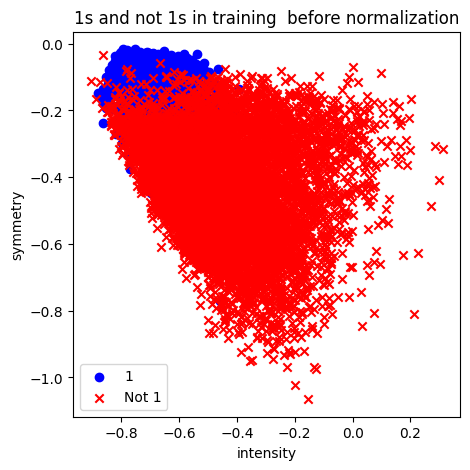

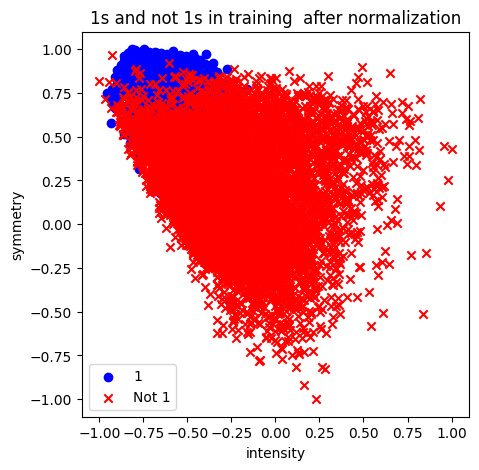

In [ ]:
# Test
digit_idxs_train = indexDigits(Xaug)
print(digit_idxs_train)
X1train = Xaug[digit_idxs_train[1], :]
N1train = X1train.shape[0]
print(f'number of 1s: {N1train}')
len(digit_idxs_train.pop(1))
rest_all_indxs =  sum(digit_idxs_train.values(), [])
X_rest_train = Xaug[rest_all_indxs, :]
N_rest_train = X_rest_train.shape[0]
print(f'number of rest datas: {N_rest_train}')
'''
Plot the training data
'''
fig, axs = plt.subplots(figsize=(5,5))
axs.scatter(X1train[:, 1], X1train[:, 2], marker='o', color='blue', label='1')
axs.scatter(X_rest_train[:, 1], X_rest_train[:, 2], marker='x', color='red', label = 'Not 1')
#axs.scatter(Xaug[:, 1], Xaug[:, 2], marker='o', color='blue', label='1')
#axs.scatter(X[:, 1], X_rest_train[:, 2], marker='x', color='red', label = 'Not 1')
axs.set_xlabel('intensity')
axs.set_ylabel('symmetry')
#axs.set_xlim(-1, 0.2)
#axs.set_ylim(1, 2)
axs.set_title('1s and not 1s in training  before normalization')
axs.legend()
#########################################################################################################
digit_idxs_train = indexDigits(Xnorm)
X1train = Xnorm[digit_idxs_train[1], :]
N1train = X1train.shape[0]
print(f'number of 1s: {N1train}')
len(digit_idxs_train.pop(1))
rest_all_indxs =  sum(digit_idxs_train.values(), [])
X_rest_train = Xnorm[rest_all_indxs, :]
N_rest_train = X_rest_train.shape[0]
print(f'number of rest datas: {N_rest_train}')
'''
Plot the training data
'''
fig, axs = plt.subplots(figsize=(5,5))
axs.scatter(X1train[:, 1], X1train[:, 2], marker='o', color='blue', label='1')
axs.scatter(X_rest_train[:, 1], X_rest_train[:, 2], marker='x', color='red', label = 'Not 1')
axs.set_xlabel('intensity')
axs.set_ylabel('symmetry')
#axs.set_xlim(-1, 0.2)
#axs.set_ylim(1, 2)
axs.set_title('1s and not 1s in training  after normalization')
axs.legend()

##### Well okay, it seems convenient to do some things this way

### Setup Labels for the 1s vs Non 1s Classification Task

In [ ]:
for n in range(N):
    if ycombined[n, 0] == 1:
        ycombined[n, 0] = 1
    else:
        ycombined[n, 0] = -1

## Train-Test Split

### Randomly select $K$ data points from the input data

In [ ]:
#test
import random
random.shuffle(Xnorm)
td = Xnorm[:int((len(Xnorm)+1) - 301)]
tst_data = Xnorm[int((len(Xnorm)+1) - 301):]
print(Xnorm.shape[0])
print(td.shape[0])
print(tst_data.shape[0])

9298
8998
300


In [ ]:
import random
def splitDataSelectKRandomly(X, y, K):
    '''
    Partitions the input dataset with N data points given by X and y into two parts,
    one with K of the data points selected uniformly at random, and
    the other with the remaining N-K data points
    Input:
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        K: an integer; number of data points to select
    Output:
        Xselected: a 2 dimensional K x d numpy array, K data points selected from X uniformly at random
        yselected: a 2 dimensional K x 1 numpy array, the labels from the input y corresponding to the examples selected in Xselected
        Xremaining: a 2 dimensional N-K x d numpy array
        yremaining: a 2 dimensional N-K x 1 numpy array
    '''
    N, d = X.shape
    # random.shuffle(Xnorm)
    # td = Xnorm[:int((len(Xnorm)+1) - 301)]
    # tst_data = Xnorm[int((len(Xnorm)+1) - 301):]
    indices = np.random.choice(N, K, replace=False)
    Xselected = X[indices, :]
    yselected = y[indices, :]
    Xremaining = np.delete(X, indices, axis=0)
    yremaining = np.delete(y, indices, axis=0)

    return Xselected, yselected, Xremaining, yremaining

In [ ]:
from sklearn import preprocessing
#Xnorm = preprocessing.normalize(Xaug)
#change later
X, y, Xtest, ytest = splitDataSelectKRandomly(Xaug, ycombined, 300)
X = normalize(X,-1,1)
Xtest = normalize(Xtest,-1,1)
#print(X)
#print(y)
#xtemp, ytemp, xtest1, ytest1 = splitDataSelectKRandomly(Xaug, ycombined, 300)
print(f'Xnorm shape {Xnorm.shape} ycombined shape {ycombined.shape}\n\
X shape {X.shape} y shape {y.shape}\n\
Xtest shape {Xtest.shape}, ytest shape {ytest.shape}')

colstats
[-0.67741797 -0.38576562 -0.45190625 -0.25905078 -0.6945625  -0.25403906
 -0.63483594 -0.615      -0.79987891 -0.082      -0.45833984 -0.71494141
 -0.55514453 -0.6301875  -0.17682031 -0.097      -0.57713281 -0.07698437
 -0.48917578 -0.22206641 -0.44803906 -0.67021094 -0.30580859 -0.74362891
 -0.42908984 -0.36864844 -0.54970703 -0.37485547 -0.635125   -0.80111719
 -0.27811719 -0.30375781 -0.49148438 -0.49910156 -0.07501172 -0.54693359
 -0.5409375  -0.73970312 -0.46769531 -0.43294531 -0.57238281 -0.61409375
 -0.66399609 -0.73592187 -0.71842969 -0.48853906 -0.07809375  0.01970703
 -0.61500391 -0.33805469 -0.45186328 -0.50891016 -0.54512109 -0.60817188
 -0.03328906 -0.46095703 -0.51355859 -0.56416406 -0.68617969 -0.52439062
 -0.55770312 -0.47603516 -0.54869922 -0.60155859 -0.34480859 -0.45632031
 -0.30721094 -0.71589844 -0.63807812 -0.72397266 -0.22136719 -0.59314062
 -0.70118359 -0.56422656 -0.68675781 -0.41999219 -0.40252734 -0.37642187
 -0.59461719 -0.23754688 -0.58583203 -0.52

### Visualize the Data

[ 23  43  56  58  69  89  92  93 100 102 116 120 126 149 160 164 167 168
 171 176 188 196 205 207 214 224 226 234 241 251 262 267 269 273 277]
-0.14157651914457303
-0.9727914404763466
1.0
0.40593626090838275


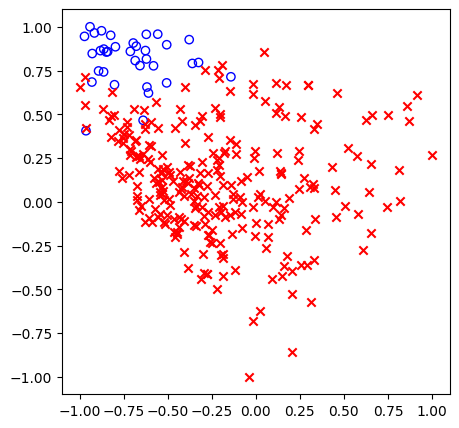

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))
plus1s = np.where(y == 1)[0]
minus1s = np.where(y == -1)[0]
Xplus1s = X[plus1s, :]
#Xplus1snotNormal = xtemp[plus1s, :]
Xminus1s = X[minus1s, :]
#Xminus1snotNormal = xtemp[minus1s, :]
axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
            color='blue', facecolors='none', label='1')
#axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
#            color='blue', facecolors='none', label='1')
axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
            marker='x', color='red', label='Not 1')
print(plus1s)
print(max(Xplus1s[:, 1]))
print(min(Xplus1s[:, 1]))
print(max(Xplus1s[:, 2]))
print(min(Xplus1s[:, 2]))

## Polynomial Transform Revisited - Using Legendre Polynomials

### Compute the Legendre Polynomials at a value of the input variable $x$

For non-negative integer $q$, let $L_q(x)$ denote the $q$-th degree Legendre polynomial

$L_0(x)=1$

$L_1(x)=x$

And for any $k\in\{2,3,\dots\}$

$L_k(x)=\frac{2k-1}{k}xL_{k-1}(x) - \frac{k-1}{k}L_{k-2}(x)$

See LFD Problem 4.3 for more details.

In [ ]:
def LegendrePolynomials(x, Q):
    '''
    Compute the values of Legendre polynomials with degrees 0, 1, 2, ..., Q at the input x
    Input:
        x: a real number
        Q: a positive integer
    Output:
        L: a list with Q+1 entries,
           where for any k=0, 1, ..., Q,
           L[k] is the value of the k-th order Legendre polynomial at x
    '''
    L = [1, x]
    # TODO: Complete the implementation Done
    #now trying

    L = [0] * (Q + 1)
    if Q >= 0:
        L[0] = 1
    if Q >= 1:
        L[1] = x

    for k in range(2, Q + 1):
        L[k] = ((2 * k - 1) / k) * x * L[k - 1] - ((k - 1) / k) * L[k - 2]

    return L

### Compute the Legendre Polynomial Feature Transform

$\begin{bmatrix} 1\\ x_1\\ x_2\end{bmatrix} \to
\begin{bmatrix} 1\\ L_1(x_1)\\ L_1(x_2)\\ L_2(x_1)\\ L_1(x_1)L_1(x_2)\\ L_2(x_2)\\ L_3(x_1)\\ L_2(x_1)L_1(x_2)\\ L_1(x_1)L_2(x_2)\\ L_3(x_2)\\ \vdots \end{bmatrix}$

In [ ]:
from itertools import permutations
from itertools import combinations_with_replacement
def polynomialTransformLegendre(X, Q):
    '''
    Compute the Legendre Polynomial Feature Transform
    See LFD Example 3.3
    Input:
        X: A 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        Q: The desired degree of polynomial
    Output:
        Z: A 2 dimensional N x d_tilde numpy array
           The n-th row Z[n, :] contains features corresponding to the Q-th order polynomial transform of X[n, :]
           Z[n, 0] = 1
           Z[n, 1], ..., Z[d_tilde] contain the transformed features
    Warning and TODO: This is a hack! Can we do better?
    '''
    N, d = X.shape
    if np.all(X[:, 0] == np.ones((N, 1))):
        X = X[:, 1:]
    N, d = X.shape

    '''
    Setup
    '''
    degrees = range(Q+1)
    perms = permutations(range(d))
    perms = list(perms)
    combs = combinations_with_replacement(degrees, d)
    combs = list(combs)
    '''
    List feature names
    '''
    terms = []
    ftnames = []
    for c in combs:
        if np.sum(c) == 0:
            continue
        if np.sum(c) > Q:
            continue
        for p in perms:
            ftname = '*'.join(sorted([f'L_{c[col]}(x[{p[col]}])' for col in range(d)]))
            if ftname in ftnames:
                continue
            terms.append((c, p))
            ftnames.append(ftname)
    '''
    Compute features
    '''
    Z = []
    for n in range(N):
        row = [1]
        x = X[n, :]
        z = []
        Ls = [LegendrePolynomials(x[col], Q) for col in range(d)]
        for t in terms:
            (c, p) = t
            v = np.prod([Ls[p[i]][c[i]] for i in range(d)])
            z.append(v)
        z = [1] + z
        Z.append(z)
    Z = np.array(Z)
    return Z

In [ ]:

Z = polynomialTransformLegendre(X, 6)
print(f'Z shape {Z.shape}')
Ztest = polynomialTransformLegendre(Xtest, 6)
print(f'Ztest shape {Ztest.shape}')

Z shape (300, 28)
Ztest shape (8998, 28)


# **Task1 : 10th Order Polymnomial Transform **

In [ ]:

Z10 = polynomialTransformLegendre(X, 10)
print(f'Z shape {Z10.shape}')
Ztest10 = polynomialTransformLegendre(Xtest, 10)
print(f'Ztest shape {Ztest10.shape}')

Z shape (300, 66)
Ztest shape (8998, 66)


In [ ]:
'''
Updated plotting routine to use Legendre Polynomial transform instead
'''
from matplotlib.colors import ListedColormap

##test
def predictClassLinear(w, X):
    '''
    Predict the class labels for a set of data points using a linear model
    Input:
        w: a d x 1 2-dimensional numpy array of weights for a linear hypothesis
        X: a 2-dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the dataset
    Output:
        yhat: a 2-dimensional N x 1 numpy array
              yhat[i, 0] is the predicted class label for the i-th example
    '''
    # Compute the linear combination of weights and features
    z = np.dot(X, w)

    # Apply a threshold to classify as 1 or -1
    yhat = np.where(z >= 0, 1, -1)

    return yhat



def plotNonLinearSeparator(w, X, y, Q=2, title=''):
    '''
    Plot the "effective" decision boundary and half spaces
    determined by a non-linear separator in 2D space
    which is picked from a linear model in higher dimensional space
    using the polynomial transform
    Input:
        w: a d x 1 2 dimensional numpy array of weights for a linear hypothesis
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        Q: The desired degree of polynomial
        title: a string
    Output:
        No output
    '''
    fig, axs = plt.subplots(figsize=(10, 10))
    '''
    Plot separator
    '''
    pltx1s = np.linspace(-1, 1, 100)
    pltx2s = np.linspace(-1, 1, 100)
    pltX = np.array([[1, x, y] for x in pltx1s for y in pltx2s])
    # a function that performs the polynomial transform
    pltZ = polynomialTransformLegendre(pltX, Q)
    pltyhat = predictClassLinear(w, pltZ)
    pltx1s = pltX[:, 1].reshape((pltX.shape[0], 1))
    pltx2s = pltX[:, 2].reshape((pltX.shape[0], 1))
    cmap = ListedColormap(['lightcoral', 'lightskyblue'])
    axs.scatter(pltx1s, pltx2s, c=pltyhat, cmap=cmap)
    '''
    Plot data points
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')
    '''
    Finishing touches
    '''
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_title(title)
    axs.legend()
    plt.show()

## Linear Regression with Regularization: The One Step $E_\text{aug}$ Minimizing Algorithm

Minimize the augmented error with weight decay regularization. See Lecture 11.

Given:

- $X$: $N\times d$ 'augmented' matrix of $N$ data points with $d$ features.

- $y$: $N\times 1$ vector of labels

- $\lambda$: Regularization parameter

Compute weights $w$ to represent a linear hypothesis which has minimum augmented error $E_{\text{aug}}(w)=E_{\text{in}}(w) + \lambda w^T w$. Here:
- $E_{\text{in}}(w)=\frac{1}{N}(w^TX^TXw-2w^TX^Ty+y^Ty)$ is the sum of squared errors of the predictions made by the linear hypothesis with weights $w$, whose predictions are given by the $N\times 1$ vector $\hat{y}=Xw$.
- $\lambda w^T w$ is the weight decay regularization term which penalizes a linear hypothesis with weights $w$ by $\lambda$ times the sum of squares of the components of the weights.

Output $w_\text{reg}\in\arg\min_{w\in\mathbb{R}^d}E_{\text{aug}}(w)$.

$w_{\text{reg}}\gets (X^TX + \lambda I)^{-1}X^T y$, if $X$ is invertible.

##### Tip: See <a href="https://numpy.org/doc/stable/reference/generated/numpy.identity.html#numpy-identity">numpy.identity()</a> to produce the identity matrix. You may continue to use <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html#numpy-linalg-pinv">numpy.linalg.pinv()</a> to compute the inverse of a matrix, even one which is invertible.

### Sum of Squared Errors

Given:

- $X$: $N\times d$ 'augmented' matrix of $N$ data points with $d$ features.

- $y$: $N\times 1$ vector of labels See Lecture 11.

$E_{X,y}(w)=\frac{1}{N}(w^TX^TXw-2w^TX^Ty+y^Ty)$ is the sum of squared errors of the predictions made by the linear hypothesis with weights $w$, whose predictions are given by the $N\times 1$ vector $\hat{y}=Xw$.

In [ ]:
'''
The Sum or Squared Errors
'''

def squaredError(w, X, y):
    '''
    point-wise sum of squared error (for regression)
    Input:
        w: a d x 1 2 dimensional numpy array
        X: an N x d 2 dimensional numpy array
        y: an N x 1 2 dimensional numpy array
    Output:
        error: sum of squared errors of hypothesis w on data points in X with true labels y
    '''
    # TODO: Complete this implementation
    y_pred = np.dot(X, w)

    squared_errors = (y - y_pred) ** 2

    error = np.sum(squared_errors)/N

    return error

### Linear Regression with Regularization

Given:

- $X$: $N\times d$ 'augmented' matrix of $N$ data points with $d$ features.

- $y$: $N\times 1$ vector of labels

- $\lambda$: Regularization parameter

Output $w_\text{reg}\in\arg\min_{w\in\mathbb{R}^d}E_{\text{aug}}(w)$, where $E_{\text{aug}}(w)=E_{\text{in}}(w) + \lambda w^T w$.

$w_{\text{reg}}\gets (X^TX + \lambda I)^{-1}X^T y$, if $X$ is invertible.

In [ ]:
'''
The one-step optimal algorithm for Linear Regression
'''
from numpy.linalg import inv
def linearRegressionRegularized(X, y, lamda):
    '''
    Implements the one-step algorithm for Linear Regression
    Input:
        X: A 2 dimensional N x d numpy array
           The i-th row X[i, :] contains features for the i-th example in the training set
           X[i, 0] = 1
           X[i, 1], ... X[i, d] have values of features
        y: A 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        lamda: a non-negative real number which controls the amount of regularization
               called lamda instead of lambda because python has an in-built lambda
    Output:
        w: weights with lowest error on the input training set X, y
    '''
    N, d = X.shape
    # TODO: Compute the optimal weights which minimizes the sum of squared errors
    N, d = X.shape
    I = np.identity(d)
    XTX = np.dot(X.T, X)

    w = np.dot(np.dot(inv(XTX + lamda * I), X.T), y)
    return w

### Experiments with Linear Regression with Regularization

In [ ]:
lamda = 0
w_reg = linearRegressionRegularized(Z, y, lamda)

#for polynomial transform of 10th degree
w_reg_10 = linearRegressionRegularized(Z10 , y ,lamda)

NameError: ignored

# **TASK 2 : Plot deciosn boundary for lamda =0**

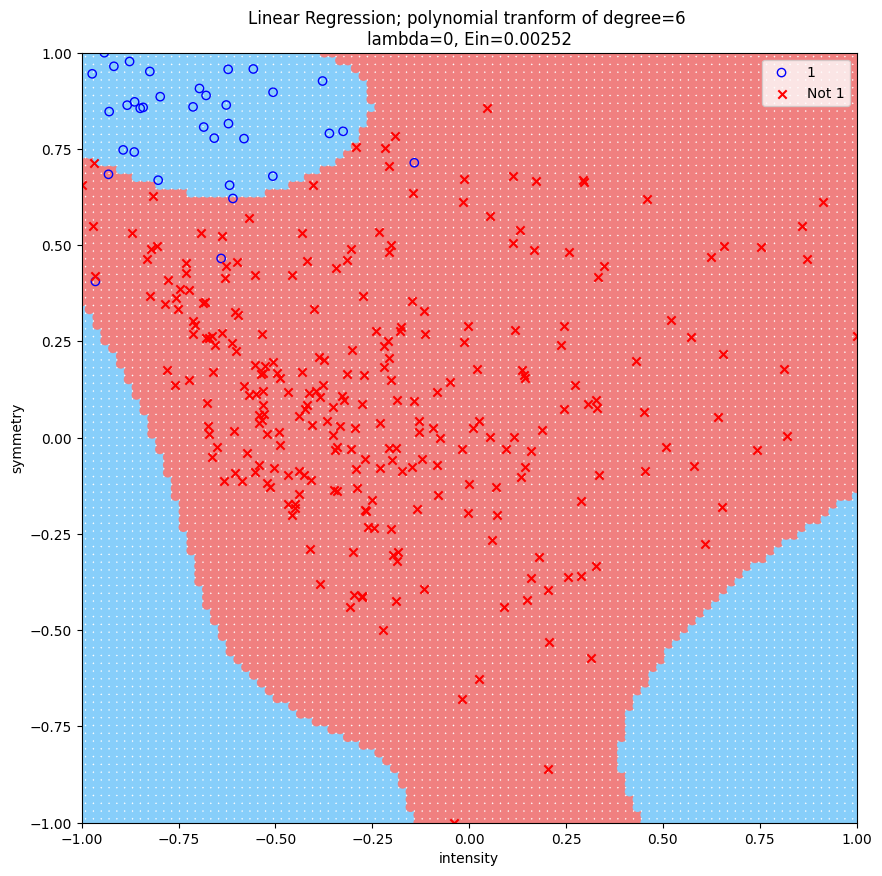

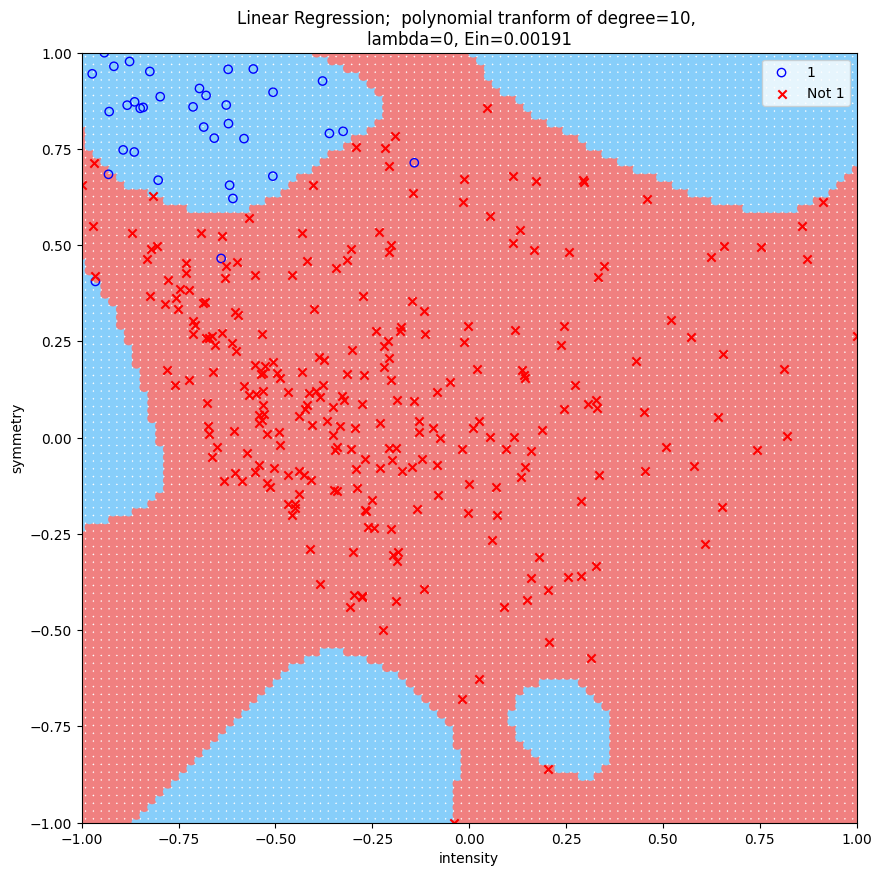

In [ ]:
Ein = np.round(squaredError(w_reg, Z, y), 5)
plotNonLinearSeparator(w_reg, X, y, Q=6,
                           title=f'Linear Regression; polynomial tranform of degree=6 \nlambda={lamda}, Ein={Ein}')

# for 10th Order transform
Ein_10 = np.round(squaredError(w_reg_10, Z10, y), 5)
plotNonLinearSeparator(w_reg_10, X, y, Q=10,
                           title=f'Linear Regression;  polynomial tranform of degree=10, \nlambda={lamda}, Ein={Ein_10}')


# **Task 3 : Plot decision boundary for lamda = 3 **

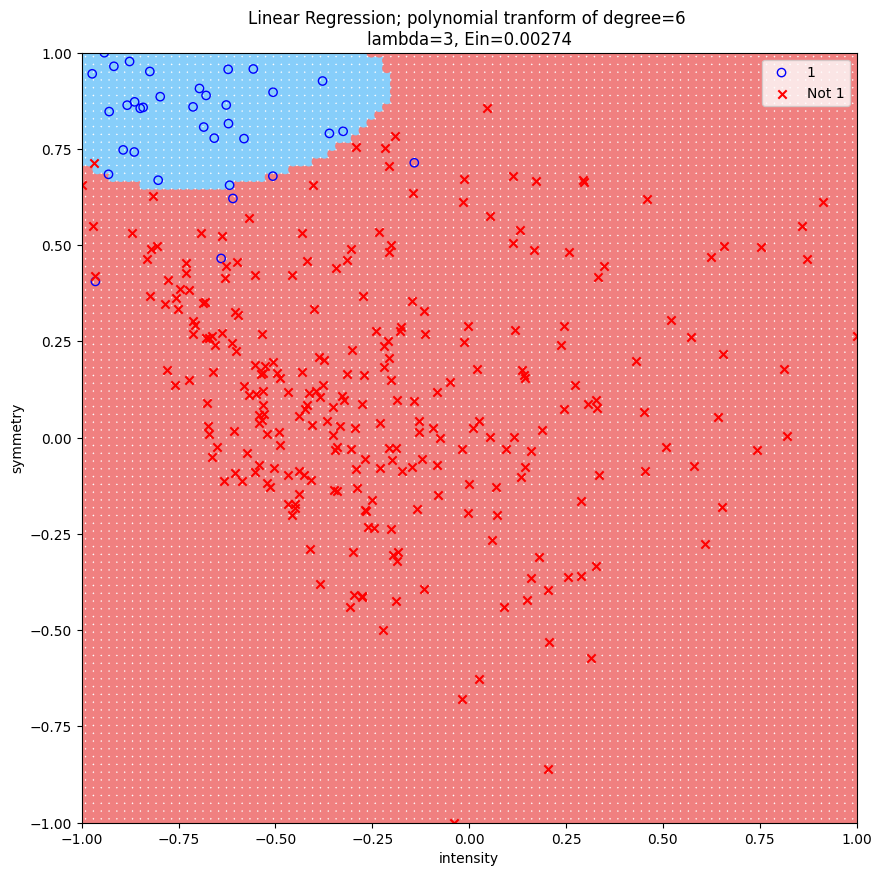

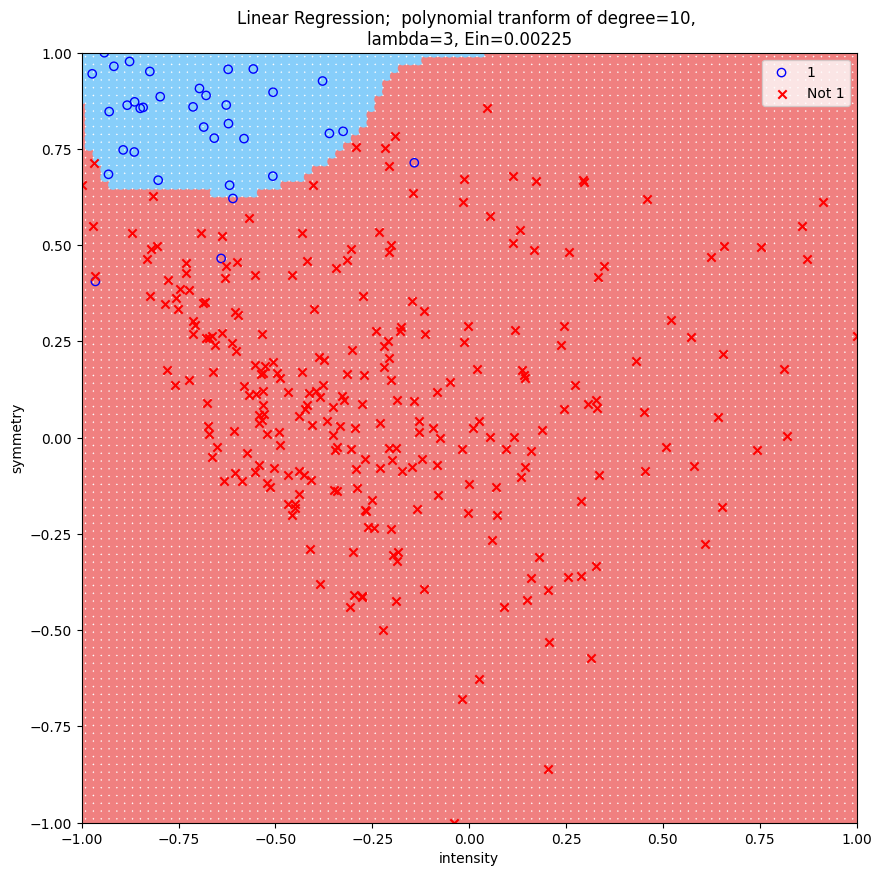

In [ ]:
lamda = 3
w_reg = linearRegressionRegularized(Z, y, lamda)
Ein = np.round(squaredError(w_reg, Z, y), 5)
plotNonLinearSeparator(w_reg, X, y, Q=6,
                           title=f'Linear Regression; polynomial tranform of degree=6 \nlambda={lamda}, Ein={Ein}')

### for polynomial trnasform of degree 10
w_reg_10 = linearRegressionRegularized(Z10 , y ,lamda)
Ein_10 = np.round(squaredError(w_reg_10, Z10, y), 5)
plotNonLinearSeparator(w_reg_10, X, y, Q=10,
                           title=f'Linear Regression;  polynomial tranform of degree=10, \nlambda={lamda}, Ein={Ein_10}')


In [ ]:
lamda = 10
w_reg = linearRegressionRegularized(Z, y, lamda)

In [ ]:
#Ein = np.round(squaredError(w_reg, Z, y), 5)
#plotNonLinearSeparator(w_reg, X, y, Q=Q,
#                           title=f'Linear Regression; \nlambda={lamda}, Ein={Ein}')

## Leave-One-Out Cross Validation

See Lectures 22 and 23

In [ ]:
def linearRegressionCVError(X, y, lamda):
    '''
    Implements the one-step algorithm for Linear Regression
    Input:
        X: A 2 dimensional N x d numpy array
           The i-th row X[i, :] contains features for the i-th example in the training set
           X[i, 0] = 1
           X[i, 1], ... X[i, d] have values of features
        y: A 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        lamda: a non-negative real number which controls the amount of regularization
               called lamda instead of lambda because python has an in-built lambda
    Output:
        Ecv: The leave one out cross validation error of linear regression with regularization parameter lamda on data X, y
    '''
    N, d = X.shape
    I = np.identity(d)
    Ecv = 0

    for i in range(N):
        X_train = np.delete(X, i, axis=0)
        y_train = np.delete(y, i, axis=0)
        X_test = X[i:i+1]
        y_test = y[i:i+1]

        XTX = np.dot(X_train.T, X_train)
        w = np.dot(np.dot(inv(XTX + lamda * I), X_train.T), y_train)
        y_pred = np.dot(X_test, w)
        Ecv += (y_test - y_pred) ** 2

    Ecv /= N
    return Ecv

### Experiments with Leave-One-Out Cross Validation

In [ ]:
lamda = 0
Ecv = linearRegressionCVError(Z, y, lamda)
print(f'Linear Regression with Regularization with lambda={lamda}, Ecv = {Ecv}')

Linear Regression with Regularization with lambda=0, Ecv = [[0.11999158]]


### Experiments to Pick Regularization Parameter $\lambda$

Please try other values of $\lambda$ as well.

# **Task 4 : find test error and Ecv and plot against lamda **

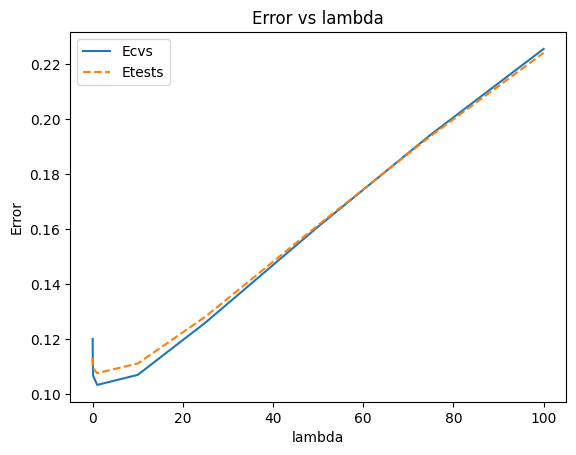

In [ ]:
#find test Error
lamdas = [0, 0.001, 0.01, 0.1, 1, 10, 25, 50, 75, 100]

# find weights for all lambdas
Etests = []
for lamda in lamdas:
    w_reg = linearRegressionRegularized(Z, y, lamda) #train
    Etest = squaredError(w_reg, Ztest, ytest)
    Etests.append(Etest)

#Ecvs
Ecvs = []
for lamda in lamdas:
    Ecv = linearRegressionCVError(Z, y, lamda)
    Ecvs.append(Ecv)

Ecvs =  np.array([x[0, 0] for x in Ecvs])
Ecvs
#plot Etest vs lambda  && Ecv vs lambda
plt.plot(lamdas,Ecvs)
plt.plot(lamdas,Etests , linestyle = 'dashed')
plt.xlabel("lambda")
plt.ylabel("Error")
plt.title("Error vs lambda")
plt.legend(["Ecvs", "Etests"])
# plt.show()

# **Task 5 : get optimal lambda and plot decison boundary**

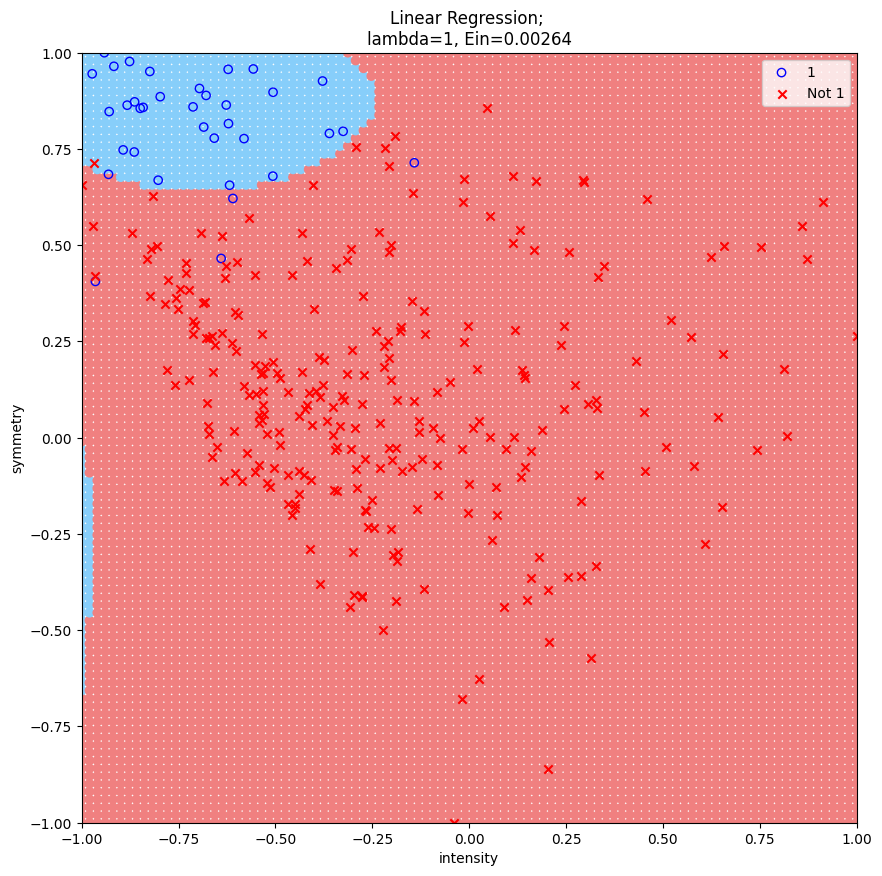

In [ ]:
optlamda = lamdas[np.argmin(Ecvs)]

w_reg_optimal = linearRegressionRegularized(Z, y, optlamda)
Ein_optimal_lambda = np.round(squaredError(w_reg_optimal, Z, y), 5)
plotNonLinearSeparator(w_reg_optimal, X, y, Q=6,
                           title=f'Linear Regression; \nlambda={optlamda}, Ein={Ein_optimal_lambda}')



# **Task 6 :Estimate Classification Error.**





In [ ]:
# find classification Error
Eout_optimal = np.round(squaredError(w_reg_optimal, Ztest, ytest), 5)

# find Error bar N = 300 , dvc =2 ##test  , delta = 0.01
penalty =  np.sqrt((0.08/3)* np.log(4* (2 * 301)/ 0.01) / np.log(math.e) )
print("Penalty =", penalty)
Eout_estimated = Ein_optimal_lambda + penalty

print("Eout Actual =" ,Eout_optimal, " , Eout Estimated =" , Eout_estimated )


Penalty =  0.574844256992954
Eout Actual =  0.10752  Eout Estimated =  0.577484256992954


# **Task 7 : Is CV biased ?**

# **Task 8 : Remaining**


In [ ]:
#!jupyter nbconvert --to html ML_HW_3_RegularizationValidationHW.ipynb
!jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/ML_HW_3_RegularizationValidationHW.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/ML_HW_3_RegularizationValidationHW.ipynb to html
[NbConvertApp] Writing 2666588 bytes to /content/drive/MyDrive/Colab Notebooks/ML_HW_3_RegularizationValidationHW.html
